In [193]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [194]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

In [195]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import itertools

## Load Data

In [196]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [197]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])
x = x.as_matrix()
# x = standardize = preprocessing.scale(x)

In [198]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,log_volume
96,96,2017.11.22,3600,0.80 s.tifheightmap.mat,3.246003,2078,3636.158141,0.965494,1,0.546842,1.749835,[[2.07800000e+03 1.12295000e+05 7.50542500e+06...,-1.408393,250.551299,[[ 65.34587122 -105.42900115]\r\n [-105.42900...,1,1,8.198683
395,93_flipped,2017.11.22,1800,6.80 s.tifheightmap.mat,5.070634,4676,11830.638042,0.974598,1,0.428205,2.530077,[[4.67600000e+03 3.91785000e+05 4.31880770e+07...,-1.425538,455.847763,[[ 158.40076381 -307.5813893 ]\r\n [-307.58138...,2,1,9.378448
178,178,2017.11.23,3600,63.41 s.tifheightmap.mat,7.557547,1761,8003.187696,0.516807,1,0.626913,4.544684,[[1.76100000e+03 4.37900000e+04 1.36807200e+06...,1.081748,166.409163,[[133.39356704 18.65943251]\r\n [ 18.65943251...,0,1,8.987595
377,77_flipped,2017.11.22,1800,12.59 s.tifheightmap.mat,8.562641,3641,10439.409357,0.953193,1,0.386450,2.864035,[[3.64500000e+03 2.50714000e+05 2.16705220e+07...,-1.184230,392.433550,[[ 307.51733073 -442.34137532]\r\n [-442.34137...,2,1,9.253343
137,137,2017.11.23,1800,30.40 s.tifheightmap.mat,12.672682,7138,51565.232138,0.762010,1,0.581065,7.211921,[[7.15000000e+03 3.91770000e+05 2.49082840e+07...,0.262741,435.847763,[[1008.79867512 152.90892718]\r\n [ 152.90892...,0,1,10.850603


In [199]:
test_size = int(df.shape[0]/10)

x_test = np.array(x[:test_size])
y_test = df['flow_rate'][:test_size].values

x_train = np.array(x[test_size:])
y_train = df['flow_rate'][test_size:].values

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std        

In [200]:
print(np.bincount(y_train))
np.bincount(y_test)

[  0   0   0 ...   0   0 107]


array([0, 0, 0, ..., 0, 0, 9], dtype=int64)

## Run Logistic Regression

In [201]:
batch_size = 16
nb_classes = 3
nb_epoch = 20

lmda = 0.01

In [202]:
input_dim = x_train.shape[1]

In [203]:
y_train[y_train == 1800] = 0
y_train[y_train == 3600] = 1
y_train[y_train == 7200] = 2

y_test[y_test == 1800] = 0
y_test[y_test == 3600] = 1
y_test[y_test == 7200] = 2

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [204]:
def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))

    return model

In [205]:
model = None
model = build_logistic_model(input_dim, nb_classes)

In [206]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 3)                 39        
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [207]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 362 samples, validate on 40 samples
Epoch 1/20
362/362 [==============================] - 2s 6ms/step - loss: 1.5146 - acc: 0.3287 - val_loss: 1.3488 - val_acc: 0.3250
Epoch 2/20
362/362 [==============================] - 0s 312us/step - loss: 1.4301 - acc: 0.3315 - val_loss: 1.3154 - val_acc: 0.3250
Epoch 3/20
362/362 [==============================] - 0s 366us/step - loss: 1.3612 - acc: 0.3619 - val_loss: 1.2868 - val_acc: 0.3250
Epoch 4/20
362/362 [==============================] - 0s 257us/step - loss: 1.3078 - acc: 0.3646 - val_loss: 1.2673 - val_acc: 0.3500
Epoch 5/20
362/362 [==============================] - 0s 281us/step - loss: 1.2648 - acc: 0.3674 - val_loss: 1.2518 - val_acc: 0.3000
Epoch 6/20
362/362 [==============================] - 0s 272us/step - loss: 1.2326 - acc: 0.3702 - val_loss: 1.2384 - val_acc: 0.2750
Epoch 7/20
362/362 [==============================] - 0s 305us/step - loss: 1.2060 - acc: 0.3785 - val_loss: 1.2259 - val_acc: 0.2750
Epoch 8/20
362/362 

In [208]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.1350850105285644
Test accuracy: 0.35


## Confusion Matrix

In [209]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[1 2 1 1 1 1 1 0 0 1 1 0 2 2 0 1 0 2 0 1 0 1 0 1 2 0 2 0 0 0 1 1 1 0 0 2 0
 1 1 2]


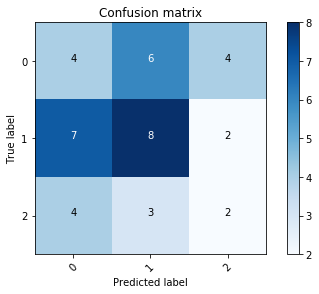

In [210]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

print(Y_pred_classes)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## With Cross Validation

In [211]:
batch_size = 16
nb_classes = 3
nb_epoch = 20

In [212]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]

In [213]:
n_folds = 10

labels = df['flow_rate'].values
data = x

labels[labels == 1800] = 0
labels[labels == 3600] = 1
labels[labels == 7200] = 2

labels = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['flow_rate'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, labels[train], x_test, labels[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(labels[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 360 samples, validate on 42 samples
Epoch 1/20
360/360 [==============================] - 3s 8ms/step - loss: 1.2657 - acc: 0.3694 - val_loss: 1.3278 - val_acc: 0.3095
Epoch 2/20
360/360 [==============================] - 0s 392us/step - loss: 1.2360 - acc: 0.3750 - val_loss: 1.3077 - val_acc: 0.2857
Epoch 3/20
360/360 [==============================] - 0s 371us/step - loss: 1.2130 - acc: 0.3556 - val_loss: 1.2903 - val_acc: 0.2857
Epoch 4/20
360/360 [==============================] - 0s 424us/step - loss: 1.1940 - acc: 0.3639 - val_loss: 1.2759 - val_acc: 0.3095
Epoch 5/20
360/360 [==============================] - 0s 400us/step - loss: 1.1772 - acc: 0.3611 - val_loss: 1.2631 - val_acc: 0.3095
Epoch 6/20
360/360 [==============================] - 0s 379us/step - loss: 1.1645 - acc: 0.3694 - val_loss: 1.2515 - val_acc: 0.3095
Epoch 7/20
360/360 [==============================] - 0s 375us/step - loss: 1.1537 - acc: 0.3778 - val_loss: 1.2388 - val_acc: 0.3333

361/361 [==============================] - 0s 371us/step - loss: 1.0702 - acc: 0.4543 - val_loss: 1.2056 - val_acc: 0.2927
Running Fold 4 / 10
Train on 361 samples, validate on 41 samples
Epoch 1/20
361/361 [==============================] - 3s 9ms/step - loss: 1.2356 - acc: 0.3934 - val_loss: 1.2973 - val_acc: 0.3171
Epoch 2/20
361/361 [==============================] - 0s 401us/step - loss: 1.2040 - acc: 0.3989 - val_loss: 1.2800 - val_acc: 0.3171
Epoch 3/20
361/361 [==============================] - 0s 409us/step - loss: 1.1758 - acc: 0.3961 - val_loss: 1.2672 - val_acc: 0.3415
Epoch 4/20
361/361 [==============================] - 0s 380us/step - loss: 1.1548 - acc: 0.3934 - val_loss: 1.2578 - val_acc: 0.3415
Epoch 5/20
361/361 [==============================] - 0s 396us/step - loss: 1.1373 - acc: 0.3961 - val_loss: 1.2488 - val_acc: 0.3659
Epoch 6/20
361/361 [==============================] - 0s 388us/step - loss: 1.1230 - acc: 0.4017 - val_loss: 1.2422 - val_acc: 0.3902
Epoch 7/20

362/362 [==============================] - 0s 412us/step - loss: 1.0884 - acc: 0.4199 - val_loss: 1.0866 - val_acc: 0.4750
Epoch 20/20
362/362 [==============================] - 0s 412us/step - loss: 1.0847 - acc: 0.4254 - val_loss: 1.0850 - val_acc: 0.4500
Running Fold 7 / 10
Train on 363 samples, validate on 39 samples
Epoch 1/20
363/363 [==============================] - 3s 8ms/step - loss: 1.8710 - acc: 0.3388 - val_loss: 1.5334 - val_acc: 0.3590
Epoch 2/20
363/363 [==============================] - 0s 383us/step - loss: 1.7230 - acc: 0.3444 - val_loss: 1.4547 - val_acc: 0.3333
Epoch 3/20
363/363 [==============================] - 0s 389us/step - loss: 1.6002 - acc: 0.3581 - val_loss: 1.3950 - val_acc: 0.3333
Epoch 4/20
363/363 [==============================] - 0s 368us/step - loss: 1.5013 - acc: 0.3636 - val_loss: 1.3538 - val_acc: 0.3590
Epoch 5/20
363/363 [==============================] - 0s 363us/step - loss: 1.4225 - acc: 0.3691 - val_loss: 1.3259 - val_acc: 0.3590
Epoch 6/2

363/363 [==============================] - 0s 365us/step - loss: 1.1022 - acc: 0.4187 - val_loss: 1.0276 - val_acc: 0.4872
Epoch 19/20
363/363 [==============================] - 0s 376us/step - loss: 1.0981 - acc: 0.4298 - val_loss: 1.0258 - val_acc: 0.4615
Epoch 20/20
363/363 [==============================] - 0s 351us/step - loss: 1.0930 - acc: 0.4380 - val_loss: 1.0243 - val_acc: 0.4615
Running Fold 10 / 10
Train on 363 samples, validate on 39 samples
Epoch 1/20
363/363 [==============================] - 3s 9ms/step - loss: 1.2594 - acc: 0.3774 - val_loss: 1.3265 - val_acc: 0.3333
Epoch 2/20
363/363 [==============================] - 0s 387us/step - loss: 1.2319 - acc: 0.3802 - val_loss: 1.3143 - val_acc: 0.3333
Epoch 3/20
363/363 [==============================] - 0s 367us/step - loss: 1.2078 - acc: 0.3884 - val_loss: 1.3062 - val_acc: 0.3333
Epoch 4/20
363/363 [==============================] - 0s 353us/step - loss: 1.1876 - acc: 0.3994 - val_loss: 1.2970 - val_acc: 0.3846
Epoch 5

In [214]:
print("Average Score: ", avg_acc/n_folds)

Average Score:  0.3653839464690798


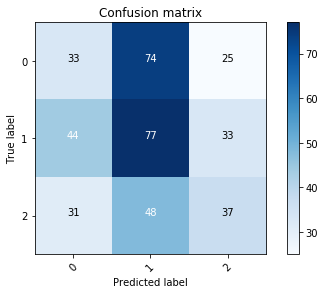

In [215]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 